<a href="https://colab.research.google.com/github/wilkieolin/VSA-notebooks/blob/main/VSA_Introduction_1_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In my opinion, a collection of techniques for manipulating symbols known collectively as "vector-symbolic architectures" (VSAs) (or equivalently, "hyperdimensional computing", HDC) provides an exciting set of methods for representing
and manipulating information. Much of my own research seeks to utilize VSAs, but in presenting it I find that outside of a small (but growing) community, VSAs are not well-known (for instance, in the realm of conventional AI and CS).

Several good articles exist to introduce those interested to VSAs - my two favorites are [An Introduction to Hyperdimensional Computing for Robotics](https://link.springer.com/article/10.1007/s13218-019-00623-z) and its companion article [A Comparison of Vector Symbolic Architectures](https://arxiv.org/pdf/2001.11797). These articles do an excellent job of going into the technical details of VSAs, how they can be applied, and the different ways in which they are implemented. 

However, I found that the best way to begin understanding VSAs was to simply begin using them. Many of the core concepts of VSAs are relatively simple to implement and have clear analogs to traditional computer science tools. In this notebook, I include code for computing with one implementation of a VSA, the [Fourier Holographic Reduced Representation (FHRR)](https://ieeexplore.ieee.org/abstract/document/377968). 

# Motivation

The central processing unit (CPU) of a computer contains specialized hardware to represent and manipulate a certain set of mathematical objects: integers, floating-points, and matrices of these values. Everything a computer does - from spreadsheets to videos and AI knowledge models - is built using these atomic representations and manipulated with the instruction set architecture (ISA) of the processor(s) being used. 

As traditional scaling of computer components becomes increasingly challenging, the efficient representation and manipulation of information within a processor is now one of the chief challenges computer manufacturers are looking to improve. This is one of the motivations behind NVIDIA's attempt to acquire Arm and the increasing popularity of the open-source RISC-V ISA. 

However, radically different representations of information can offer alternate avenues to provide efficient, high-speed, and reliable computing. With VSAs, we aim to create computers which compute with concepts. Such a computer stores and manipulates 'symbols,' atomic pieces of information which can represent abstract features like 'cat,' 'eat,' and 'food.' How then should we physically represnt each of these concepts, and manipulate them together to represent a new concept such as "the cat eats the food?" Vector-symbolic architectures provide paths for accomplishing these calculations effectively. 

# Vector-Symbols

Each vector-symbolic architecture provides a method for defining and manipulating symbols. The common feature between VSAs is that each symbol is stored as a long series of values, or 'vector.' In one VSA, [binary spatter codes](https://link.springer.com/article/10.1007/s12559-009-9009-8) (BSC), binary vectors are used - each symbol is a long list of values which are either 0 or 1. The FHRR representation instead uses a list of angles from (-π to π in radians). For the assumptions behind VSAs to operate correctly, a vector-symbol must have at least hundreds of elements, and VSA operations improve by scaling up to thousands of elements or more. We'll explore this scaling in more detail below.

To create a vector-symbol, you can select a series of random values on the domain defined by the VSA. As a default choice, we're using the FHRR VSA with a dimensionality of 1000 (each symbol is a vector of 1000 angles).

In [1]:
import jax.numpy as jnp
from jax import jit
from jax import random

import matplotlib.pyplot as plt

In [2]:
#create a helper function to generate random symbols
def generate_symbols(key, number: int, dimensionality: int):
  return random.uniform(key, minval=-1.0, maxval=1.0, shape=(number, dimensionality))

#create the key used to generate random values with JAX
key = random.PRNGKey(42)

#set the dimensionality of the VSA
dimensionality = 1000

#create the first symbol
symbol_0 = generate_symbols(key, 1, dimensionality)

In [3]:
def plot_symbol(symbol):
  plt.figure(dpi=100, figsize=(10,1))
  plt.pcolor(symbol[0:1,0:100], cmap="hsv")
  plt.colorbar()

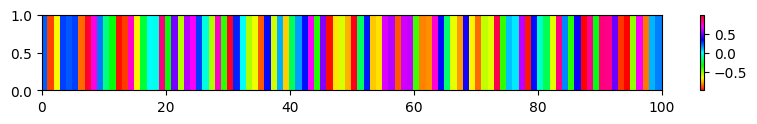

In [4]:
plot_symbol(symbol_0)

As you can see, we've now created our first vector-symbol. It has 1000 values between -1 and 1, which can be multiplied by π to produce an angle in radians, or 180 to produce an angle in degrees. We can represent this as a "color barcode," where each stripe represents the position of an angle around a unit circle. Here, we plot only the first 100 angles for clarity. 

# Similarity

So what makes a vector-symbol useful? It can be compared with other symbols by a pre-defined metric, referred to as *similarity.* Symbols which are identical have a similarity of 1, and symbols which are unrelated have a similarity of (approximately) 0.

One of the astonishing properties of high-dimensional spaces which VSAs leverage is the phenomenon that with certain metrics and vectors, the similarity of random vectors tends towards 0 as the vectors become longer. To demonstrate this, we'll first define the similarity metric for the FHRR VSA and then explore it as dimensionality shifts.

For the FHRR VSA, the similarity between two symbols is just the average of the cosine of difference in angles between the two vectors:

In [5]:
#similarity of FHRR vectors is defined by the average cosine of the difference between each angle in the two symbols being compared.
@jit
def similarity(a,b):
    assert a.shape[-1] == b.shape[-1], "VSA Dimension must match: " + str(a.shape) + " " + str(b.shape)
    #multiply values by pi to move from (-1, 1) to (-π, π)
    pi = jnp.pi
    a = jnp.multiply(a, pi)
    b = jnp.multiply(b, pi)
    #calculate the mean cosine similarity between the vectors
    similarity = jnp.mean(jnp.cos(a - b), axis=1)
    return similarity

Now that we've defined our similarity metric, let's create a second random symbol to compare with the first one.

In [6]:
#move the PRNG to the next state (see JAX documentation for details)
key, subkey = random.split(key)
symbol_1 = generate_symbols(subkey, 1, dimensionality)

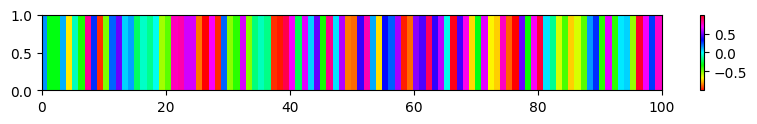

In [7]:
plot_symbol(symbol_1)

In [8]:
similarity(symbol_0, symbol_1).item()

0.00473695108667016

As you can see, the similarity between the two random symbols is extremely small - 0.004. If this just seems like coincidence, let's repeat it with 10,000 random symbols. 

In [9]:
key, subkey = random.split(key)
codebook_0 = generate_symbols(subkey, 10000, dimensionality)
similarities = similarity(symbol_0, codebook_0)

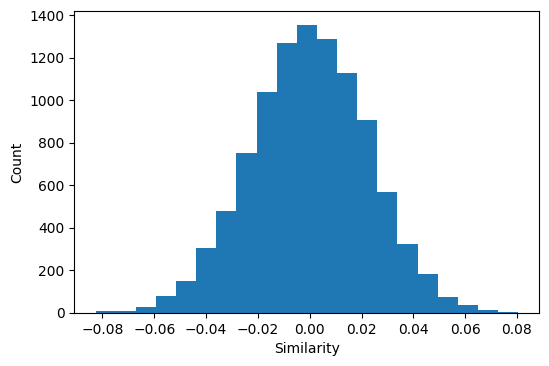

In [10]:
plt.figure(dpi=100)
plt.hist(similarities, bins=21);
plt.xlabel("Similarity")
plt.ylabel("Count");

As you can see, the similarity between random vectors turns out to be a Gaussian distribution centered around zero. This is essentially a consequence of the central limit theorem applied to this specific case. So, how long does the vector-symbol need to be for the similarity of random vectors to be approximately zero? We can run a quick experiment to estimate this empirically.

In [11]:
trials = 10000
dimension_range = jnp.arange(10, 1001, step=10, dtype=int)

In [12]:
def generate_trials(key, trials, dimensionalities):
  #find the size of a matrix large enough for all trials
  total_range = jnp.cumsum(dimension_range)
  #generate that matrix
  key, subkey = random.split(key)
  all_values = generate_symbols(subkey, trials + 1, total_range[-1])
  #slice it into codebooks, each of the appropriate size
  codebooks = jnp.split(all_values, total_range[0:-1], axis=1)

  return key, codebooks

In [13]:
key, cbs = generate_trials(key, 10000, dimension_range)

In [14]:
def estimate_orthogonality(symbols):
  #calculate the similarity between the first symbol and all others
  similarities = similarity(symbols[0:1, :], symbols[1:, :])
  #calculate the first two moments of the sample
  mean = jnp.mean(similarities)
  std = jnp.std(similarities)

  return jnp.array([mean, std])

In [15]:
estimates = jnp.array(list(map(estimate_orthogonality, cbs)))

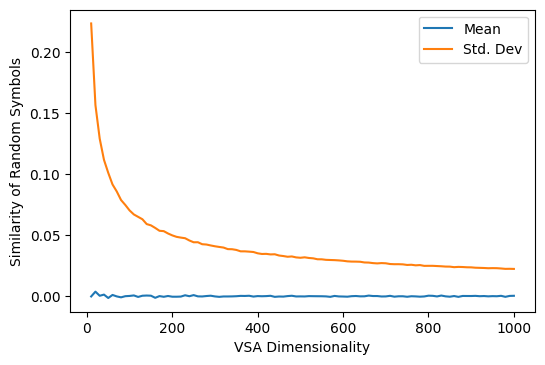

In [16]:
plt.figure(dpi=100)
plt.plot(dimension_range, estimates[:,0], label="Mean")
plt.plot(dimension_range, estimates[:,1], label="Std. Dev")
plt.xlabel("VSA Dimensionality")
plt.ylabel("Similarity of Random Symbols")
plt.legend()

As we can see, the distribution of the similarity between random vectors is always centered around zero, but becomes much more sharply peaked at zero as the dimensionality of the vector-symbol increases. In fact, this is an exponential relationship, which we can see by using a log-log chart:

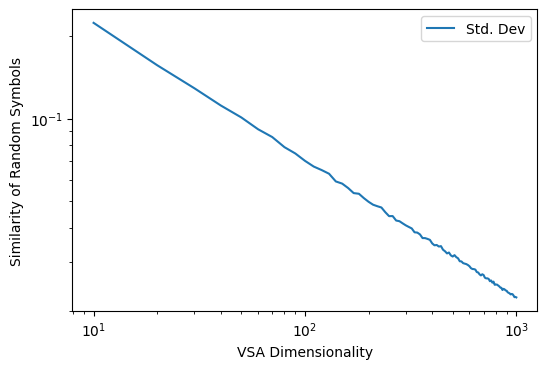

In [17]:
plt.figure(dpi=100)
plt.loglog(dimension_range, estimates[:,1], label="Std. Dev")
plt.xlabel("VSA Dimensionality")
plt.ylabel("Similarity of Random Symbols")
plt.legend()

# Part 1 Summary

So, given that random symbols in a VSA are approximately dissimilar, how does this help us construct a useful system for computation? The problem of computing in VSAs essentially becomes the problem of how to manipulate the construction of symbols in a space so that a certain relationship between two symbols is represented by their similarity.

One of the simplest methods for accomplishing this is an operation which is called *bundling*, which will be demonstrated next. We'll see that the number of items which can be retrieved from a bundle successfully is directly related to the VSA dimensionality.
